In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import logomaker
import mavenn

%matplotlib notebook

In [2]:
style_file_name = 'fig6.style'
s = """
axes.linewidth:     0.5     # edge linewidth
font.size:          7.0
axes.labelsize:     7.0  # fontsize of the x any y labels
xtick.labelsize:    7.0  # fontsize of the tick labels
ytick.labelsize:    7.0  # fontsize of the tick labels
legend.fontsize:      7.0
legend.borderpad:     0.2  # border whitespace
legend.labelspacing:  0.2  # the vertical space between the legend entries
legend.borderaxespad: 0.2  # the border between the axes and legend edge
legend.framealpha:    1.0 
"""
with open(style_file_name, 'w') as f:
    f.write(s)
    
plt.style.use(style_file_name)

In [3]:
## Define OtwinowskiGPMapLayer

# Standard TensorFlow imports
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import Constant

# Import base class
from mavenn.src.layers.gpmap import GPMapLayer

# Define custom G-P map layer
class OtwinowskiGPMapLayer(GPMapLayer):
    """
    A G-P map representing the thermodynamic model described by
    Otwinowski (2018).
    """

    def __init__(self, *args, **kwargs):
        """Construct layer instance."""

        # Call superclass constructor
        # Sets self.L, self.C, and self.regularizer
        super().__init__(*args, **kwargs)
        
        # Initialize constant parameter for folding energy
        self.theta_f_0 = self.add_weight(name='theta_f_0',
                                         shape=(1,),
                                         trainable=True,
                                         regularizer=self.regularizer)

        # Initialize constant parameter for binding energy
        self.theta_b_0 = self.add_weight(name='theta_b_0',
                                         shape=(1,),
                                         trainable=True,
                                         regularizer=self.regularizer)

        # Initialize additive parameter for folding energy
        self.theta_f_lc = self.add_weight(name='theta_f_lc',
                                          shape=(1, self.L, self.C),
                                          trainable=True,
                                          regularizer=self.regularizer)

        # Initialize additive parameter for binding energy
        self.theta_b_lc = self.add_weight(name='theta_b_lc',
                                          shape=(1, self.L, self.C),
                                          trainable=True,
                                          regularizer=self.regularizer)

    def call(self, x_lc):
        """Compute phi given x."""

        # 1kT = 0.582 kcal/mol at room temperature
        kT = 0.582

        # Reshape input to samples x length x characters
        x_lc = tf.reshape(x_lc, [-1, self.L, self.C])
        
        # Compute Delta G for binding
        Delta_G_b = self.theta_b_0 + \
                    tf.reshape(K.sum(self.theta_b_lc * x_lc, axis=[1, 2]),
                               shape=[-1, 1])
            
        # Compute Delta G for folding
        Delta_G_f = self.theta_f_0 + \
                    tf.reshape(K.sum(self.theta_f_lc * x_lc, axis=[1, 2]),
                               shape=[-1, 1])
        
        # Compute and return fraction folded and bound
        Z = 1+K.exp(-Delta_G_f/kT)+K.exp(-(Delta_G_f+Delta_G_b)/kT)
        p_bf = (K.exp(-(Delta_G_f+Delta_G_b)/kT))/Z
        phi = p_bf #K.log(p_bf)/np.log(2)
        return phi

In [4]:
model_gb1 = mavenn.load('../models/gb1_custom_lr_0.002_e_3000_ge_full_2021.12.28.12h.41m')

Model loaded from these files:
	../models/gb1_custom_lr_0.002_e_3000_ge_full_2021.12.28.12h.41m.pickle
	../models/gb1_custom_lr_0.002_e_3000_ge_full_2021.12.28.12h.41m.h5


#### Load data and define helper functions required to plot GB1 heatmaps

In [5]:
gb1_seq = model_gb1.x_stats['consensus_seq']
alphabet = model_gb1.alphabet
L = model_gb1.L
C = model_gb1.C

# Load each energy matrix and fix in the wild-type gauge
theta_dict = model_gb1.layer_gpmap.get_params()
theta_f_lc = theta_dict['theta_f_lc']
theta_b_lc = theta_dict['theta_b_lc']

# Get one-hot encoding of wt sequence
wt_ohe = mavenn.src.utils.x_to_ohe(x=gb1_seq, alphabet=alphabet).reshape([L,C])

# Fix each energy matrix in the wild-type gauge
theta_f_lc = theta_f_lc - (theta_f_lc*wt_ohe).sum(axis=1)[:,np.newaxis]
theta_b_lc = theta_b_lc - (theta_b_lc*wt_ohe).sum(axis=1)[:,np.newaxis]

# Test gauge
assert np.all(np.isclose(theta_b_lc*wt_ohe, 0))
assert np.all(np.isclose(theta_f_lc*wt_ohe, 0))

# Draw panel b (GB1 energy matrices)

In [6]:
# Get indices for aa order used in Olson et al.
ordered_aa = np.array(list('EDRKHQNSTPGCAVILMFYW'))
ix = ordered_aa.argsort()
sorted_aa = ordered_aa[ix]
ixx = ix.argsort()
sorted_aa[ixx]

array(['E', 'D', 'R', 'K', 'H', 'Q', 'N', 'S', 'T', 'P', 'G', 'C', 'A',
       'V', 'I', 'L', 'M', 'F', 'Y', 'W'], dtype='<U1')

<IPython.core.display.Javascript object>


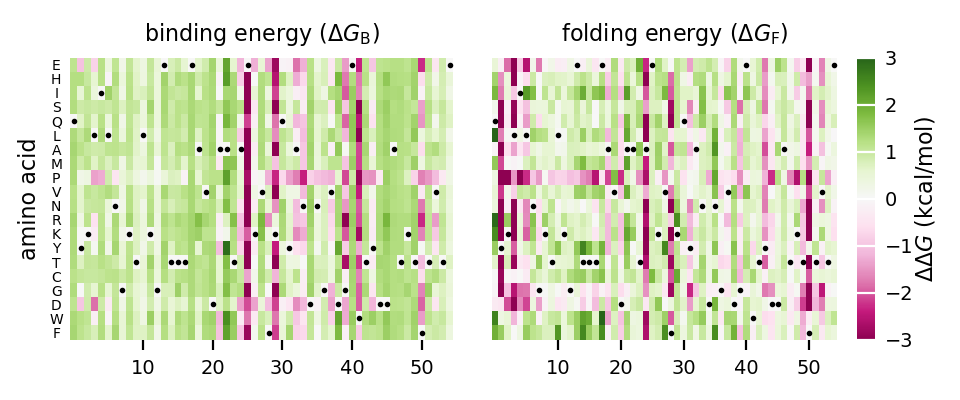

In [7]:
## heatmaps

# Create two panels
fig, axs = plt.subplots(1, 2, figsize=[4.8,2.0])
fontsize=8.0

# Left panel: draw heatmap illustrating 1pt mutation effects
ax = axs[0]
ax, cb = mavenn.heatmap(-theta_b_lc[:,ixx],
                    alphabet=alphabet[ixx],
                    seq=gb1_seq,
                    clim=[-3,3],
                    cbar=False,
                    seq_kwargs={'s':1,'c':'black'},
                    cmap='PiYG',
                    ccenter=0,
                    ax=ax)
ax.tick_params(labelsize=5, rotation=0, axis='y', length=0, pad=5)
ax.tick_params(rotation=0, axis='x')
ax.set_xticks(range(10,60,10))

#ax.set_xlabel('position',fontsize=fontsize)
ax.set_ylabel('amino acid',fontsize=fontsize,labelpad=3)
#cb.set_label('-$\Delta\Delta G$', rotation=-90, va="bottom",fontsize=fontsize)
ax.set_title('binding energy ($\Delta G_\mathrm{B}$)',fontsize=fontsize)


ax = axs[1]
# Left panel: draw heatmap illustrating 1pt mutation effects
ax, cb1 = mavenn.heatmap(-theta_f_lc[:,ixx],
                        alphabet=alphabet[ixx],
                        seq=gb1_seq,
                        clim=[-3,3],
                        cmap='PiYG',
                        seq_kwargs={'s':1,'c':'black'},                         
                        ccenter=0,
                        ax=ax)
#ax.set_xlabel('position',fontsize=fontsize)
#ax.set_ylabel('amino acid ($c$)',fontsize=fontsize)
cb1.set_label('$\Delta\Delta G$ (kcal/mol)', rotation=90, fontsize=fontsize, labelpad=0)
cb1.set_ticks([-3, -2, -1, 0, 1, 2, 3])
cb1.outline.set_visible(False)
cb1.ax.tick_params(direction='in', size=10, color='white')
ax.set_title('   folding energy ($\Delta G_\mathrm{F}$)',fontsize=fontsize)
ax.tick_params(labelsize=5, rotation=0, axis='y')
ax.set_yticks([])
ax.tick_params(rotation=0, axis='x')
ax.set_xticks(range(10,60,10))

#fig.subplots_adjust(left=3, bottom=1, right=5, top=2, wspace=5, hspace=None)
# Fix up plot
fig.tight_layout(h_pad=1,w_pad=2)
fig.savefig('png/panel_b.png', bbox_inches='tight', dpi=300, facecolor='white')
plt.show()

#### Load xylE data

In [8]:
style_file_name = 'fig6.style'
s = """
axes.linewidth:     0.5     # edge linewidth
font.size:          7.0
axes.labelsize:     7.0  # fontsize of the x any y labels
axes.titlesize:     7.0
xtick.labelsize:    7.0  # fontsize of the tick labels
ytick.labelsize:    7.0  # fontsize of the tick labels
legend.fontsize:      8.0
legend.borderpad:     0.2  # border whitespace
legend.labelspacing:  0.2  # the vertical space between the legend entries
legend.borderaxespad: 0.2  # the border between the axes and legend edge
legend.framealpha:    1.0 
"""
with open(style_file_name, 'w') as f:
    f.write(s)
    
plt.style.use(style_file_name)

In [9]:
# Function to draw logos
def draw_logo(ax, df, ylim=[-1,1], highlight_color='#9981B3', highlight_alpha=0.1):
    xmin = int(df.index.min())
    xmax = int(df.index.max())
    xlim = [xmin-.5, xmax+.5]
    logo = logomaker.Logo(-0.62*df, ax=ax, center_values=True, font_name='Arial Rounded MT Bold')
    ax.set_ylim(ylim)
    ax.set_yticks([ylim[0], 0, ylim[1]])
    logo.style_xticks(anchor=0, spacing=10)
    logo.style_spines(visible=False)
    logo.highlight_position_range(xmin, xmax, alpha=highlight_alpha, color=highlight_color)  
    ax.set_ylabel('$-\Delta \Delta G$ (kcal/mol)', labelpad=-1)
    return logo


In [10]:
# Define custom G-P map layer


class sortseqGPMapLayer(GPMapLayer):
    """Represents an thermodynamic model of transcription
    regulation in E. Coli at the lac promoter, which
    contains binding sites for RNAP and CRP.
    """

    def __init__(
        self, TF_start, TF_end, RNAP_start, RNAP_end, regularizer, *args, **kwargs
    ):
        """Construct layer instance."""

        # set attributes
        self.TF_start = TF_start
        self.TF_end = TF_end
        self.RNAP_start = RNAP_start
        self.RNAP_end = RNAP_end
        self.C = kwargs["C"]
        self.regularizer = tf.keras.regularizers.L2(regularizer)

        # form helpful variables
        self.L_TF = TF_end - TF_start
        self.L_RNAP = RNAP_end - RNAP_start

        super().__init__(*args, **kwargs)

    def build(self, input_shape):
        """Build layer."""

        # define bias/chemical potential weight for crp
        self.mu_TF = self.add_weight(
            name="mu_TF",
            shape=(1,),
            initializer=Constant(1.0),
            trainable=True,
            regularizer=self.regularizer,
        )

        # define bias/chemical potential weight for rnap
        self.mu_RNAP = self.add_weight(
            name="mu_RNAP",
            shape=(1,),
            initializer=Constant(1.0),
            trainable=True,
            regularizer=self.regularizer,
        )

        # Define theta_TF_lc parameters
        theta_TF_lc_shape = (1, self.L_TF, self.C)

        self.theta_TF_lc = self.add_weight(
            name="theta_TF_lc",
            shape=theta_TF_lc_shape,
            trainable=True,
            regularizer=self.regularizer,
        )

        # Define theta_rnap_lc parameters
        theta_RNAP_lc_shape = (1, self.L_RNAP, self.C)

        self.theta_RNAP_lc = self.add_weight(
            name="theta_RNAP_lc",
            shape=theta_RNAP_lc_shape,
            trainable=True,
            regularizer=self.regularizer,
        )

        self.interaction = self.add_weight(
            name="interaction",
            shape=(1,),
            initializer=Constant(0),
            trainable=True,
            regularizer=tf.keras.regularizers.L2(0),
        )

        self.tsat = 1.0
        
        # Call superclass build
        super().build(input_shape)

    def call(self, x_lc):
        """Process layer input and return output.

        x_lc: (tensor)
            Input tensor that represents one-hot encoded
            sequence values.
        """

        # extract locations of binding sites from entire lac-promoter sequence.
        x_TF_lc = x_lc[:, self.C * self.TF_start : self.C * self.TF_end]
        x_RNAP_lc = x_lc[:, self.C * self.RNAP_start : self.C * self.RNAP_end]

        # reshape according to crp and rnap lengths.
        x_TF_lc = tf.reshape(x_TF_lc, [-1, self.L_TF, self.C])
        x_RNAP_lc = tf.reshape(x_RNAP_lc, [-1, self.L_RNAP, self.C])

        # compute delta G for crp
        phi_TF = self.mu_TF + tf.reshape(
            K.sum(self.theta_TF_lc * x_TF_lc, axis=[1, 2]), shape=[-1, 1]
        )

        # compute delta G for rnap
        phi_RNAP = self.mu_RNAP + tf.reshape(
            K.sum(self.theta_RNAP_lc * x_RNAP_lc, axis=[1, 2]), shape=[-1, 1]
        )

        # compute rate of transcription
        t = (
            (self.tsat)
            * (K.exp(-phi_RNAP) + K.exp(-phi_TF - phi_RNAP - self.interaction))
            / (
                1
                + K.exp(-phi_TF)
                + K.exp(-phi_RNAP)
                + K.exp(-phi_TF - phi_RNAP - self.interaction)
            )
        )

        # return rate of transcription
        return t


In [11]:
# Load energy matrices
model_lac = mavenn.load('../models/sortseq_custom_lr_0.001_e_1000_2021.12.28.14h.56m')
theta_dict = model_lac.layer_gpmap.get_params()

# Create dataframe for CRP emat
lac_crp_df = pd.DataFrame(columns=model_lac.alphabet, 
                          data=theta_dict['theta_TF_lc'])
lac_crp_df.index = lac_crp_df.index - 74

# Create dataframe for RNAP emat
lac_rnap_df = pd.DataFrame(columns=model_lac.alphabet, 
                           data=theta_dict['theta_RNAP_lc'])
lac_rnap_df.index = lac_rnap_df.index - 41

Model loaded from these files:
	../models/sortseq_custom_lr_0.001_e_1000_2021.12.28.14h.56m.pickle
	../models/sortseq_custom_lr_0.001_e_1000_2021.12.28.14h.56m.h5


<IPython.core.display.Javascript object>


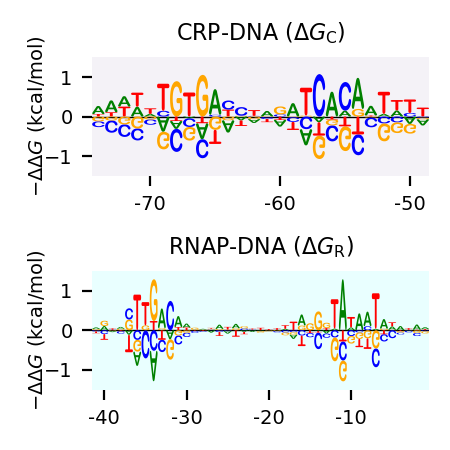

In [12]:
###
### Panel f
###

fig, axs = plt.subplots(2,1,figsize=[2.25,2.25])

# CRP logo
ax = axs[0]
lac_crp_logo = draw_logo(ax=ax, 
                         df=-lac_crp_df, 
                         ylim=[-1.5,1.5],
                         highlight_color='#9981B3', 
                         highlight_alpha=0.1)
ax.set_yticks([-1,0,1])
ax.set_title("CRP-DNA ($\Delta G_\mathrm{C}$)", fontsize=8)

# RNAP logo
ax = axs[1]
lac_rnap_logo = draw_logo(ax=ax, 
                          df=-lac_rnap_df, 
                          ylim=[-1.5,1.5],
                          highlight_color='lightcyan', 
                          highlight_alpha=0.7)
ax.set_yticks([-1,0,1])
ax.set_title("RNAP-DNA ($\Delta G_\mathrm{R}$)", fontsize=8)

# Save and show figure
fig.tight_layout(h_pad=1)
fig.savefig('png/panel_e.png',dpi=300, facecolor='white')
plt.show()

<IPython.core.display.Javascript object>


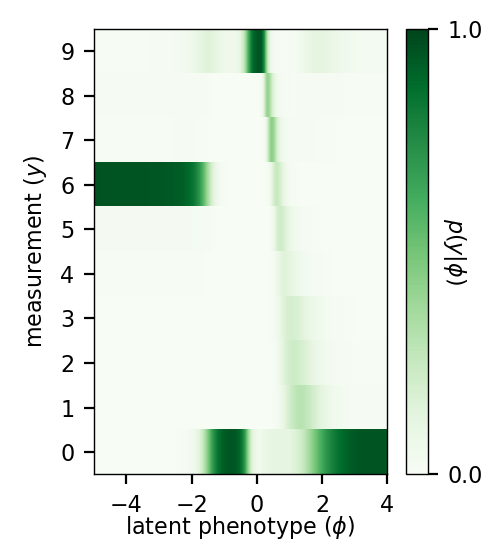

In [13]:
###
### Panel e
###

fig, ax = plt.subplots(figsize=(2.5,2.8))

# Define helper variables
phi_lim = [-5, 4]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = model_lac.Y
y_lim = [-.5, Y-.5]
y_all = list(range(Y))

# Load measurement process
#measurement_process_ss = np.load('../old/lac_emats/measurement_process_ss.npy')
p_of_y_given_phi = model_lac.p_of_y_given_phi(phi=phi_grid, y=y_all, paired=False)

# Plot measurement process
tick_spacing=10
fontsize = 8
im = ax.imshow(p_of_y_given_phi,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               vmax=1.0,
               origin='lower',
               interpolation='nearest',)
ax.set_yticks(y_all)
ax.set_ylabel('measurement ($y$)',fontsize=fontsize)
ax.set_xlabel('latent phenotype ($\phi$)',fontsize=fontsize,labelpad=-1)
ax.set_xticks([-4, -2,  0, 2, 4])
cb = plt.colorbar(im, **{'format': '%0.1f','ticks': [0, 1],}, ax=ax)
cb.ax.tick_params(labelsize=7.5)
ax.set_aspect('auto')
cb.set_label('$p(y|\phi)$', rotation=-90, va="bottom", fontsize=fontsize, labelpad=-15)
cb.ax.tick_params(labelsize=fontsize)
ax.tick_params(labelsize=fontsize)

fig.tight_layout()
fig.savefig('png/panel_d.png',dpi=300, facecolor='white')

In [31]:
# Compute parameter uncertainty
import glob
models = []
for model_num in range(20):
    file_name = f'../models/sortseq_custom_lr_0.001_e_1000_model_{model_num}_2021.12.28.14h.56m'
    model = mavenn.load(file_name, verbose=False)
    models.append(model)
    
# Once Mahdi retrains models using the fixed custom layer, refer to parameter by name
dGs = np.array([model.layer_gpmap.get_weights()[-1][0] for model in models])*0.616
print(f'dG_I = {dGs.mean():.3f} +- {dGs.std():.3f} kcal/mol')

dG_I = -3.243 +- 0.012 kcal/mol
